<a href="https://colab.research.google.com/github/HasanNayon/Anomaly-detection/blob/main/ad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tarfile
tar_file = '/content/drive/MyDrive/new/mvtec_anomaly_detection.tar.xz'
destination = '/content/mvtec_anomaly_detection'

with tarfile.open(tar_file, 'r:*') as tar:
    tar.extractall(path=destination)


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_auc_score
from skimage import morphology
from sklearn.model_selection import train_test_split

In [3]:
def load_mvtec_dataset(dataset_path, category='bottle', mode='train', target_size=(256, 256)):
    """
    Correctly loads MVTec dataset with both normal and defective test images
    """
    if mode == 'train':
        # Load only normal images for training
        normal_path = os.path.join(dataset_path, category, 'train', 'good')
        normal_images = []
        for img_name in sorted(os.listdir(normal_path)):
            img = tf.io.read_file(os.path.join(normal_path, img_name))
            img = tf.image.decode_png(img, channels=3)
            img = tf.image.resize(img, target_size)
            normal_images.append(img)
        return tf.stack(normal_images) / 255.0

    else:  # test mode
        normal_images = []
        defect_images = []
        defect_masks = []

        # 1. Load normal test images
        normal_test_path = os.path.join(dataset_path, category, 'test', 'good')
        for img_name in sorted(os.listdir(normal_test_path)):
            img = tf.io.read_file(os.path.join(normal_test_path, img_name))
            img = tf.image.decode_png(img, channels=3)
            img = tf.image.resize(img, target_size)
            normal_images.append(img)

        # 2. Load defective images and masks
        defect_types = [d for d in os.listdir(os.path.join(dataset_path, category, 'test'))
                      if d != 'good']

        for defect in defect_types:
            defect_img_path = os.path.join(dataset_path, category, 'test', defect)
            defect_mask_path = os.path.join(dataset_path, category, 'ground_truth', defect)

            for img_name in sorted(os.listdir(defect_img_path)):
                # Load defective image
                img = tf.io.read_file(os.path.join(defect_img_path, img_name))
                img = tf.image.decode_png(img, channels=3)
                img = tf.image.resize(img, target_size)
                defect_images.append(img)

                # Load corresponding mask
                mask_name = img_name.replace('.png', '_mask.png')
                if os.path.exists(os.path.join(defect_mask_path, mask_name)):
                    mask = tf.io.read_file(os.path.join(defect_mask_path, mask_name))
                    mask = tf.image.decode_png(mask, channels=1)
                else:
                    mask = tf.zeros(target_size + (1,), dtype=tf.uint8)
                mask = tf.image.resize(mask, target_size)
                mask = tf.cast(mask > 0, tf.float32)
                defect_masks.append(mask)

        # Combine normal and defective images
        all_images = tf.concat([normal_images, defect_images], axis=0) / 255.0
        all_masks = tf.concat(
            [tf.zeros((len(normal_images), *target_size, 1), dtype=tf.float32), tf.stack(defect_masks)],
            axis=0
        )

        return all_images, all_masks

        return all_images, all_masks

In [4]:
# Model Architecture
def build_mvtec_autoencoder(input_shape=(256, 256, 3)):
    """Autoencoder optimized for MVTec dataset"""
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (4, 4), activation='relu', padding='same', strides=2)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    x = layers.Conv2D(64, (4, 4), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = layers.Conv2D(128, (4, 4), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = layers.Conv2DTranspose(128, (4, 4), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = layers.Conv2DTranspose(64, (4, 4), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = layers.Conv2DTranspose(32, (4, 4), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(x)

    return models.Model(inputs, outputs)


In [5]:
#Training with MVTec-specific Setup

# Load data
dataset_path = '/content/mvtec_anomaly_detection'
category = 'bottle'

# Load training images and convert to NumPy array
train_images_tf = load_mvtec_dataset(dataset_path, category, 'train')
train_images_np = train_images_tf.numpy() # Convert TensorFlow tensor to NumPy array

# Load test data
# Correctly unpack the two returned values: all_images and all_masks
test_images, test_masks = load_mvtec_dataset(dataset_path, category, 'test')


# Split train into train/val using the NumPy array
train_images, val_images = train_test_split(train_images_np, test_size=0.1, random_state=42)

# Convert the split NumPy arrays back to TensorFlow tensors for training
train_images = tf.convert_to_tensor(train_images)
val_images = tf.convert_to_tensor(val_images)

In [6]:
# Add this diagnostic check after loading test data
print(f"Test images shape: {test_images.shape}")
print(f"Test masks shape: {test_masks.shape}")
print(f"Number of defective images: {np.sum(np.max(test_masks, axis=(1,2,3)) > 0)}/{len(test_masks)}")
print(f"Number of normal images in test set: {len(test_masks) - np.sum(np.max(test_masks, axis=(1,2,3)) > 0)}")

Test images shape: (83, 256, 256, 3)
Test masks shape: (83, 256, 256, 1)
Number of defective images: 63/83
Number of normal images in test set: 20


In [7]:
# Build and compile model
autoencoder = build_mvtec_autoencoder()
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse')

In [8]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 64)   │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 256, 256, 32)   │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 256, 256, 3)    │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 979,427 (3.74 MB)

 Trainable params: 979,427 (3.74 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Callbacks
checkpoint = callbacks.ModelCheckpoint(
    f'mvtec_{category}_best.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)


In [10]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

In [11]:
# Train
history = autoencoder.fit(
    train_images, train_images,
    validation_data=(val_images, val_images),
    epochs=20,
    batch_size=32,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - loss: 0.1316 

6/6 ━━━━━━━━━━━━━━━━━━━━ 140s 23s/step - loss: 0.1314 - val_loss: 0.1107
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 131s 22s/step - loss: 0.1292 - val_loss: 0.1281
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - loss: 0.1269 

6/6 ━━━━━━━━━━━━━━━━━━━━ 151s 23s/step - loss: 0.1265 - val_loss: 0.1018
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - loss: 0.1024 

6/6 ━━━━━━━━━━━━━━━━━━━━ 133s 22s/step - loss: 0.1020 - val_loss: 0.0839
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - loss: 0.0784 

6/6 ━━━━━━━━━━━━━━━━━━━━ 146s 23s/step - loss: 0.0776 - val_loss: 0.0601
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - loss: 0.0577 

6/6 ━━━━━━━━━━━━━━━━━━━━ 145s 23s/step - loss: 0.0575 - val_loss: 0.0514
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - loss: 0.0495 

6/6 ━━━━━━━━━━━━━━━━━━━━ 146s 24s/step - loss: 0.0492 - val_loss: 0.0453
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - loss: 0.0441 

6/6 ━━━━━━━━━━━━━━━━━━━━ 192s 22s/step - loss: 0.0440 - val_loss: 0.0418
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - loss: 0.0413 

6/6 ━━━━━━━━━━━━━━━━━━━━ 143s 23s/step - loss: 0.0412 - val_loss: 0.0400
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - loss: 0.0395 

6/6 ━━━━━━━━━━━━━━━━━━━━ 136s 23s/step - loss: 0.0395 - val_loss: 0.0388
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - loss: 0.0386 

6/6 ━━━━━━━━━━━━━━━━━━━━ 141s 24s/step - loss: 0.0386 - val_loss: 0.0379
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - loss: 0.0377 

6/6 ━━━━━━━━━━━━━━━━━━━━ 136s 22s/step - loss: 0.0376 - val_loss: 0.0370
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - loss: 0.0366 

6/6 ━━━━━━━━━━━━━━━━━━━━ 143s 23s/step - loss: 0.0366 - val_loss: 0.0350
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - loss: 0.0343 

6/6 ━━━━━━━━━━━━━━━━━━━━ 139s 22s/step - loss: 0.0343 - val_loss: 0.0321
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - loss: 0.0313 

6/6 ━━━━━━━━━━━━━━━━━━━━ 147s 23s/step - loss: 0.0311 - val_loss: 0.0253
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - loss: 0.0207 

6/6 ━━━━━━━━━━━━━━━━━━━━ 139s 23s/step - loss: 0.0201 - val_loss: 0.0109
Epoch 17/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - loss: 0.0089 

6/6 ━━━━━━━━━━━━━━━━━━━━ 138s 23s/step - loss: 0.0088 - val_loss: 0.0044
Epoch 18/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 138s 22s/step - loss: 0.0051 - val_loss: 0.0048
Epoch 19/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - loss: 0.0043 

6/6 ━━━━━━━━━━━━━━━━━━━━ 136s 23s/step - loss: 0.0043 - val_loss: 0.0035
Epoch 20/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 140s 23s/step - loss: 0.0036 - val_loss: 0.0035


In [12]:
# MVTec-specific Evaluation Metrics

def evaluate_mvtec(model, test_images, test_masks):
    # Get reconstructions and error maps
    reconstructions = model.predict(test_images)
    error_maps = np.mean(np.abs(test_images - reconstructions), axis=-1)

    # Need to convert test_masks to numpy to flatten
    flat_masks = test_masks.numpy().reshape(-1)
    flat_errors = error_maps.reshape(-1)

    # Compute image-level AUROC
    img_level_scores = np.max(error_maps, axis=(1, 2))
    # Need to convert test_masks to numpy for numpy max
    img_level_labels = np.max(test_masks.numpy(), axis=(1, 2, 3))
    img_auroc = roc_auc_score(img_level_labels, img_level_scores)

    # Compute pixel-level AUROC
    pixel_auroc = roc_auc_score(flat_masks, flat_errors)

    # Compute PRO (Per-Region Overlap)
    pro_scores = []
    max_error = np.max(error_maps)
    if max_error > 0:
        thresholds = np.linspace(0, max_error, 100)
    else:
        thresholds = [0]
    # Store overlaps for each threshold to calculate the PRO AUC at the end
    overlaps_at_thresholds = []

    for thresh in thresholds:
        binary_maps = (error_maps > thresh).astype(bool)
        current_threshold_overlaps = []

        for i in range(len(test_masks)):
            # Need to convert test_masks[i] to numpy for sum
            if np.sum(test_masks[i].numpy()) > 0:
                cleaned = morphology.remove_small_objects(
                    morphology.remove_small_holes(
                        binary_maps[i],
                    area_threshold=32),
                min_size=32)
                mask_np_bool = tf.squeeze(test_masks[i]).numpy().astype(bool)

                # Perform bitwise AND between the boolean arrays
                intersection = np.sum(cleaned & mask_np_bool)
                # Convert test_masks[i] to numpy for sum
                union = np.sum(test_masks[i].numpy())
                current_threshold_overlaps.append(intersection / union if union > 0 else 0)

        # Store the mean overlap for this threshold
        if current_threshold_overlaps:
             overlaps_at_thresholds.append(np.mean(current_threshold_overlaps))
        else:
             overlaps_at_thresholds.append(0)

    # Use np.trapz for integration.
    if len(thresholds) > 1:
        pro_score = np.trapz(overlaps_at_thresholds, thresholds) / (thresholds[-1] - thresholds[0])
    elif thresholds[0] == 0 and overlaps_at_thresholds:
        pro_score = overlaps_at_thresholds[0]
    else:
        pro_score = 0

    return {
        'image_auroc': img_auroc,
        'pixel_auroc': pixel_auroc,
        'pro_score': pro_score
    }

In [13]:
# Evaluate
metrics = evaluate_mvtec(autoencoder, test_images, test_masks)
print(f"Image-Level AUROC: {metrics['image_auroc']:.4f}")
print(f"Pixel-Level AUROC: {metrics['pixel_auroc']:.4f}")
print(f"PRO Score: {metrics['pro_score']:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step
Image-Level AUROC: 0.8429
Pixel-Level AUROC: 0.6788
PRO Score: 0.0844


<ipython-input-12-a128666ce18c>:59: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pro_score = np.trapz(overlaps_at_thresholds, thresholds) / (thresholds[-1] - thresholds[0])


In [14]:
# Visualization for MVTec Defects

def visualize_mvtec_results(images, masks, reconstructions, num_samples=5):
    """Visualize MVTec test cases with ground truth masks"""
    indices = np.random.choice(len(images), num_samples)

    plt.figure(figsize=(15, 4*num_samples))
    for i, idx in enumerate(indices):
        image_np = images[idx].numpy() if isinstance(images[idx], tf.Tensor) else images[idx]
        error_map = np.mean(np.abs(image_np - reconstructions[idx]), axis=-1)

        plt.subplot(num_samples, 4, i*4 + 1)
        # images[idx] might be a TensorFlow Tensor, convert to numpy for plotting
        plt.imshow(image_np)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(num_samples, 4, i*4 + 2)
        plt.imshow(reconstructions[idx])
        plt.title("Reconstruction")
        plt.axis('off')

        plt.subplot(num_samples, 4, i*4 + 3)
        plt.imshow(error_map, cmap='jet')
        plt.title("Error Map")
        plt.axis('off')

        plt.subplot(num_samples, 4, i*4 + 4)
        # test_masks is a TensorFlow Tensor, so .numpy() is needed here
        plt.imshow(tf.squeeze(masks[idx]).numpy(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


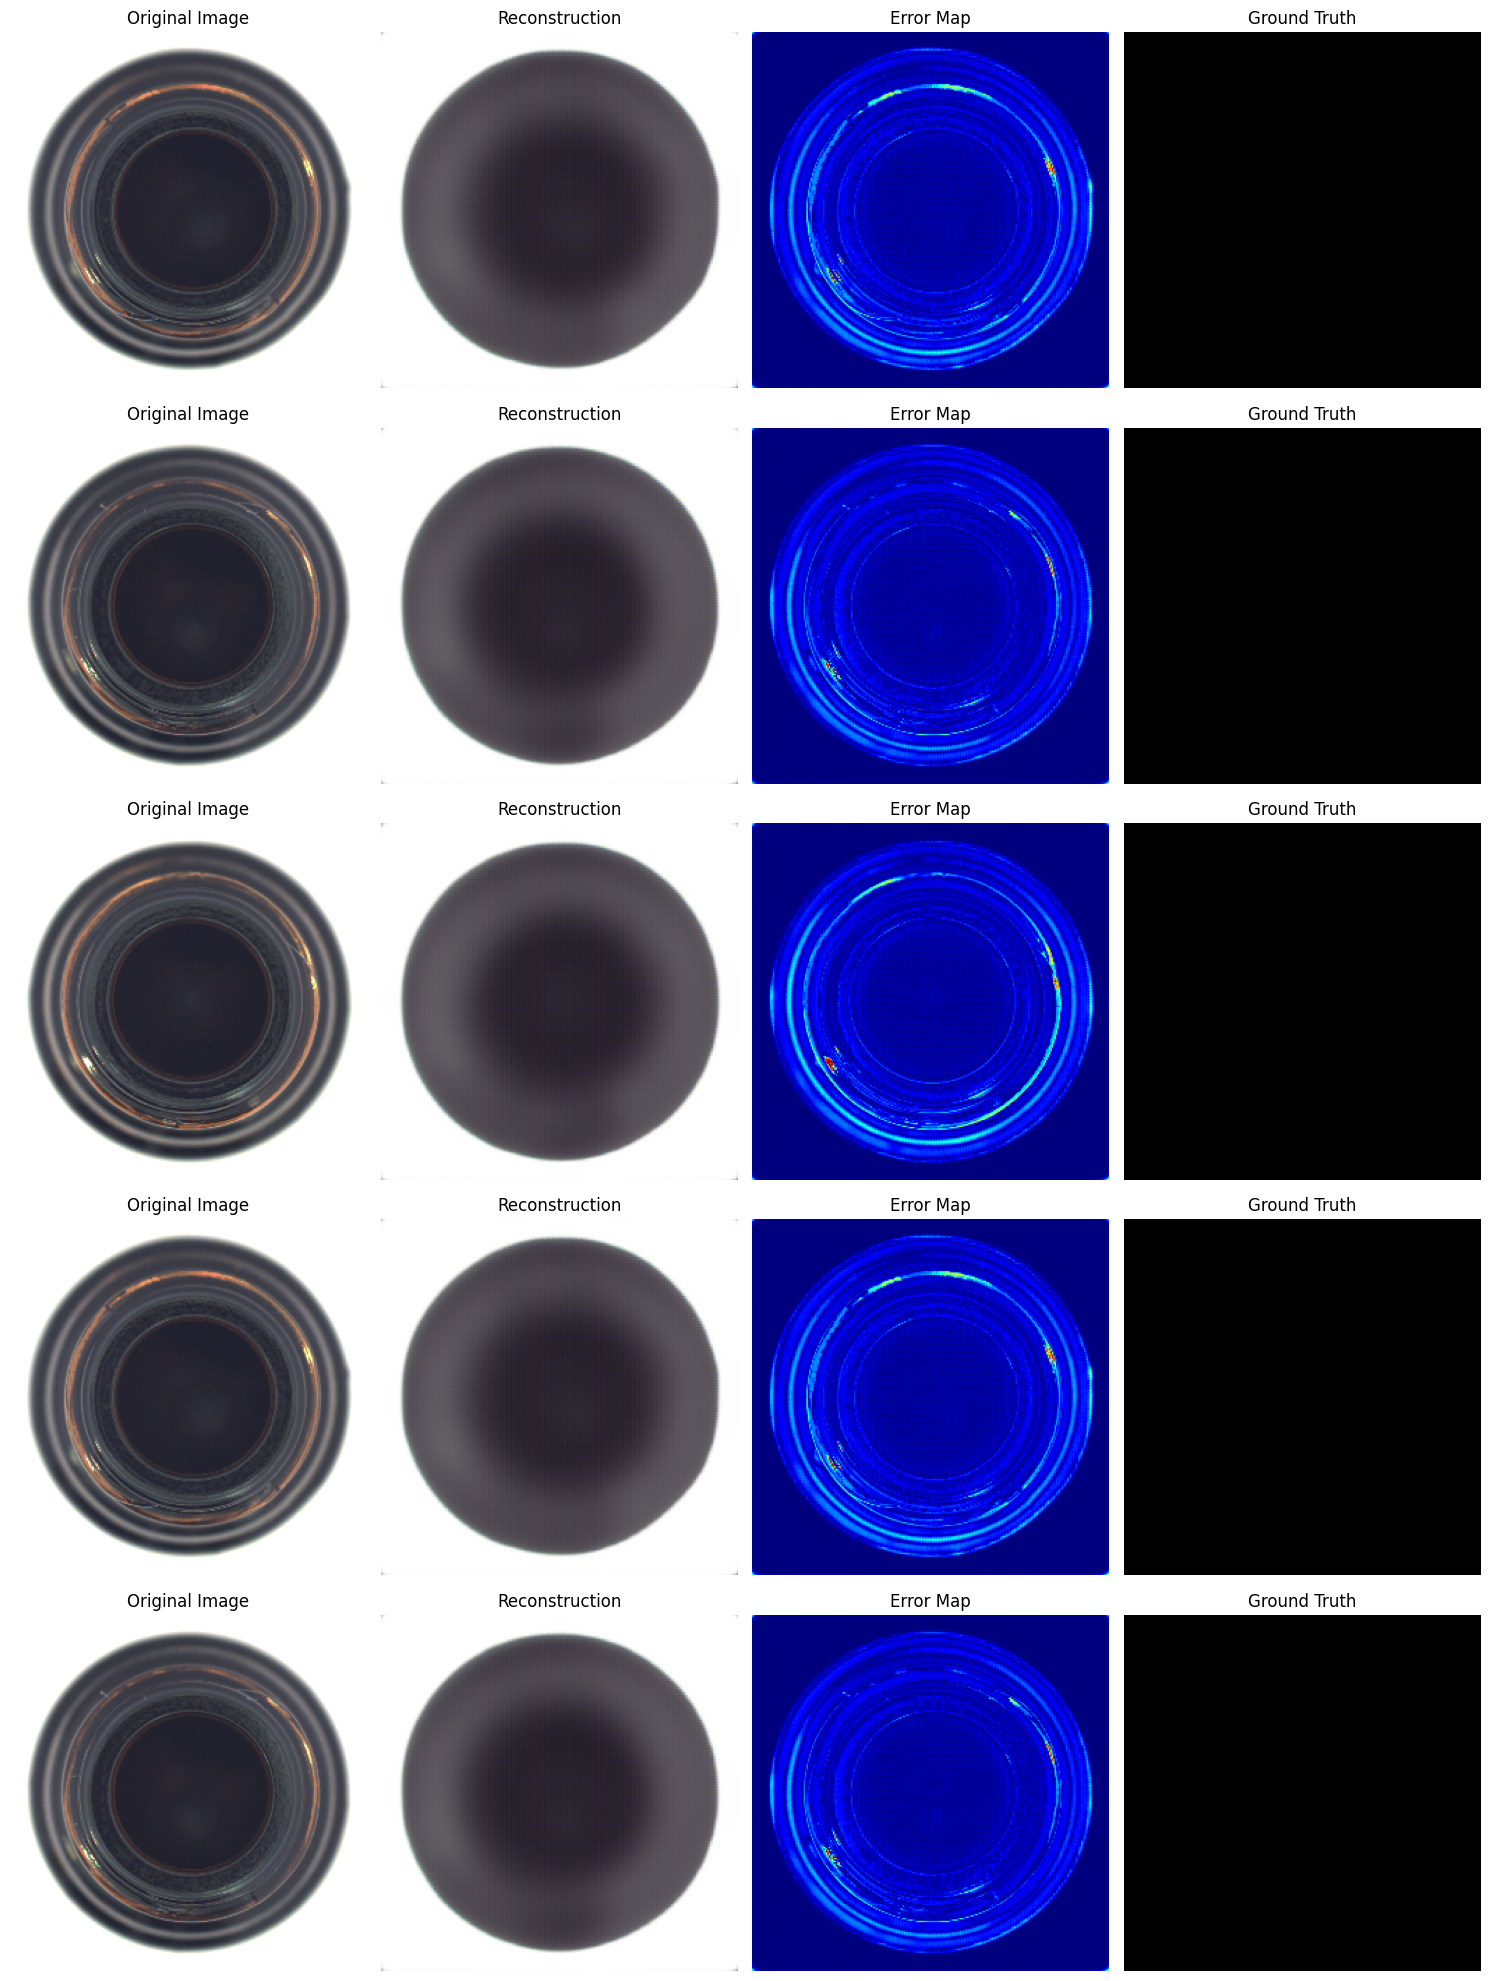

In [15]:
# Visualize some test cases
test_reconstructions = autoencoder.predict(test_images[:20])
visualize_mvtec_results(test_images[:20], test_masks[:20], test_reconstructions)

Total test images: 83
Normal test images: 20
Defective test images: 63

Normal Sample Analysis:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


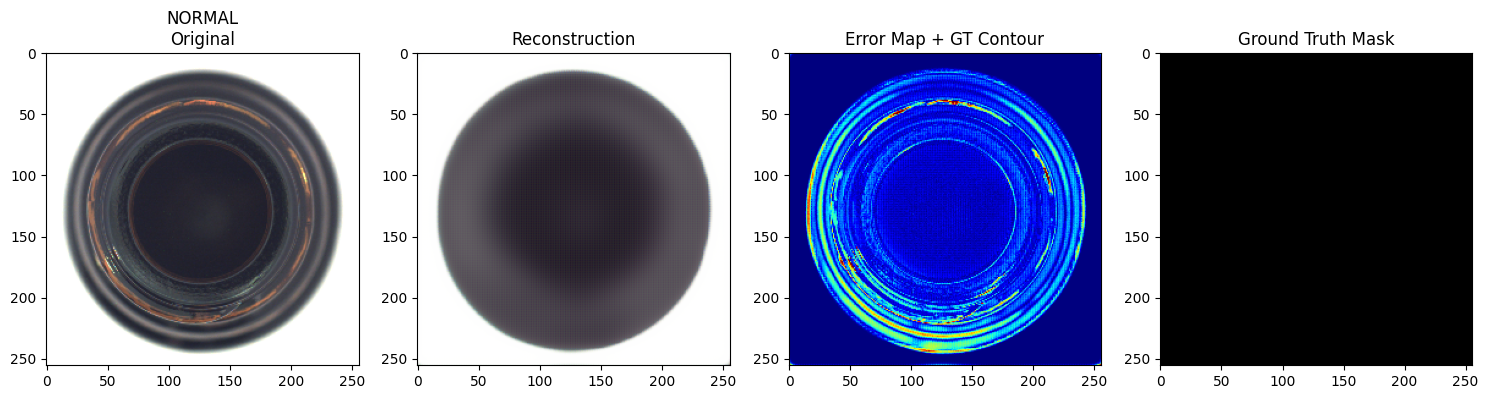

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
Mean reconstruction error (normal): 0.0345

Defective Sample Analysis:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


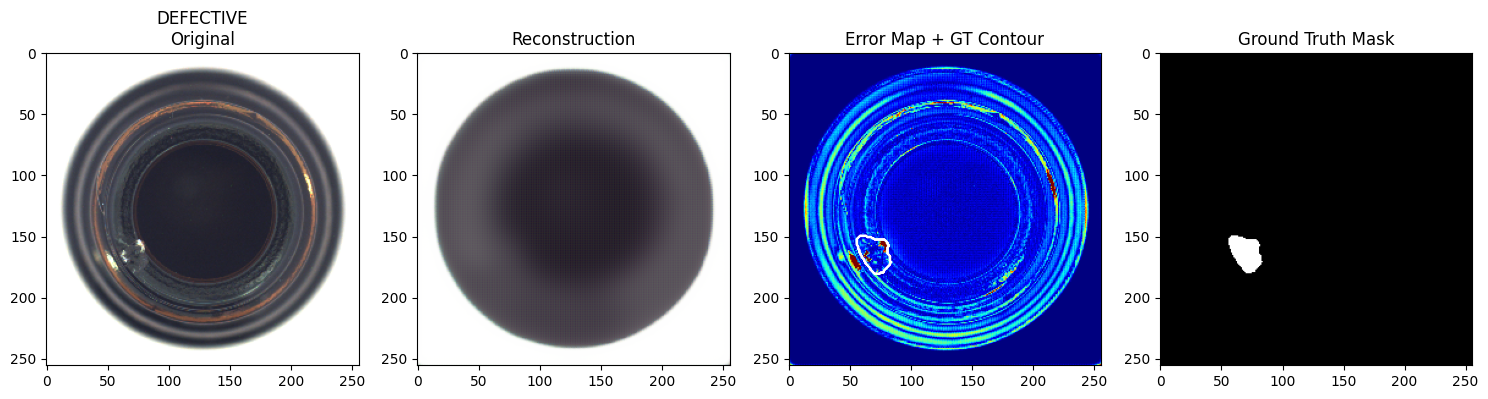

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
Mean reconstruction error (defect): 0.0347
Defect area (GT): 0.9% of image
Error ratio (defect/normal): 1.01x

Statistical Analysis:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


<ipython-input-28-2c99fc9eb4ed>:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal_errors, defect_errors], labels=['Normal', 'Defective'])


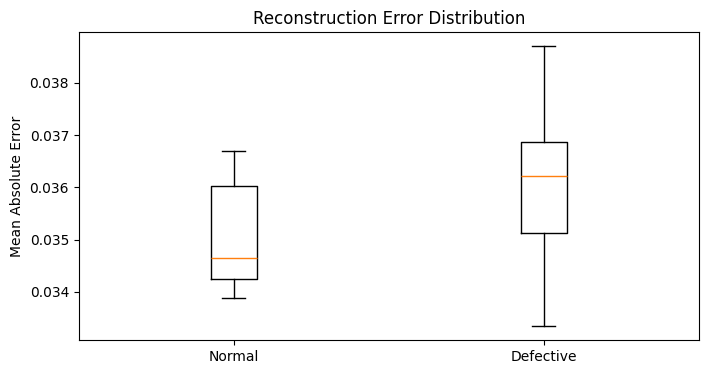

In [28]:
# Load your best model with custom objects
model = tf.keras.models.load_model(
    '/content/mvtec_bottle_best.h5',
    custom_objects={'mse': tf.keras.losses.MeanSquaredError()}
)

# Verify test set composition
test_images, test_masks = load_mvtec_dataset(dataset_path, 'bottle', 'test')
print(f"Total test images: {len(test_images)}")
print(f"Normal test images: {sum(np.max(test_masks, axis=(1,2,3)) == 0)}")
print(f"Defective test images: {sum(np.max(test_masks, axis=(1,2,3)) > 0)}")

def visualize_sample_with_gt(idx, title=""):
    """Enhanced visualization with ground truth overlay"""
    img = test_images[idx]
    gt_mask = test_masks[idx].numpy().squeeze()

    # Get model predictions
    recon = model.predict(img[np.newaxis, ...])[0]
    error_map = np.mean(np.abs(img - recon), axis=-1)

    # Create figure
    plt.figure(figsize=(15,4))

    # Original image
    plt.subplot(141)
    plt.imshow(img)
    plt.title(f"{title}\nOriginal")

    # Reconstruction
    plt.subplot(142)
    plt.imshow(recon)
    plt.title("Reconstruction")

    # Error map with ground truth contour
    plt.subplot(143)
    plt.imshow(error_map, cmap='jet', vmin=0, vmax=0.3)
    if np.max(gt_mask) > 0:  # Only plot contours for defective images
        plt.contour(gt_mask, colors='white', linewidths=1)
    plt.title("Error Map + GT Contour")

    # Ground truth mask
    plt.subplot(144)
    plt.imshow(gt_mask, cmap='gray')
    plt.title("Ground Truth Mask")

    plt.tight_layout()
    plt.show()

# Analyze samples
if len(good_indices) > 0:
    print("\nNormal Sample Analysis:")
    visualize_sample_with_gt(good_indices[0], "NORMAL")

    # Calculate metrics for normal sample
    recon_normal = model.predict(test_images[good_indices[0]][np.newaxis, ...])[0]
    normal_error = np.mean(np.abs(test_images[good_indices[0]] - recon_normal))
    print(f"Mean reconstruction error (normal): {normal_error:.4f}")

if len(bad_indices) > 0:
    print("\nDefective Sample Analysis:")
    visualize_sample_with_gt(bad_indices[0], "DEFECTIVE")

    # Calculate metrics for defective sample
    recon_defect = model.predict(test_images[bad_indices[0]][np.newaxis, ...])[0]
    defect_error = np.mean(np.abs(test_images[bad_indices[0]] - recon_defect))
    defect_gt_area = np.mean(test_masks[bad_indices[0]])
    print(f"Mean reconstruction error (defect): {defect_error:.4f}")
    print(f"Defect area (GT): {100*defect_gt_area:.1f}% of image")

    # Error ratio (defect/normal)
    if len(good_indices) > 0:
        print(f"Error ratio (defect/normal): {defect_error/normal_error:.2f}x")

# Additional statistical analysis
if len(bad_indices) > 0 and len(good_indices) > 0:
    print("\nStatistical Analysis:")
    normal_errors = [np.mean(np.abs(test_images[i] - model.predict(test_images[i][np.newaxis, ...])[0]))
                   for i in good_indices[:10]]  # First 10 normals
    defect_errors = [np.mean(np.abs(test_images[i] - model.predict(test_images[i][np.newaxis, ...])[0]))
                   for i in bad_indices[:10]]   # First 10 defects

    plt.figure(figsize=(8,4))
    plt.boxplot([normal_errors, defect_errors], labels=['Normal', 'Defective'])
    plt.title("Reconstruction Error Distribution")
    plt.ylabel("Mean Absolute Error")
    plt.show()